In [130]:
# #from SHEAP.fitting.functions import linear,GaussianSum,linear2,combine_auto
# from SHEAP.fitting.functions import GaussianSum
# from SHEAP.main_sheap import Sheapectral 
# from SHEAP.spectra_readers import parallel_reader 
# from SHEAP.complex_region.region import ComplexRegion
# from SHEAP.ploting import *
# from SHEAP.host_sub.start_method import Extract_host_star
# from SHEAP.tools.others import wl_to_kms
# from SHEAP.fe_handler import fe_template_read,galaxy_template_read
# from SHEAP.complex_region.building_region import RegionBuilder
# from SHEAP.complex_region.fit_fe import fe_template_read

In [1]:
from sheap.spectra_readers import parallel_reader 
from sheap.MainSheap import Sheapectral 
from sheap.RegionHandler.RegionBuilder import RegionBuilder
from sheap.RegionHandler.RegionFitting import RegionFitting
from sheap.ploting import *

In [2]:
import jax 
from jax import jit 
import jax.numpy as jnp
import glob 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
from paths_func import cross_pandas_spectra
jax.config.update("jax_enable_x64", True)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
path_dr16 = "/home/favila/smbh_mass/dr16"
#path_dr16 = "/home/felipe/work/SMBH_estimation/dr16"

In [135]:
#dr16/subsample_07_03_25.csv

In [5]:
#file_paths,objs_panda  = cross_pandas_spectra(path_dr16,"bernal_sdss_fits","Objects_low_stellar_mass_with_stellar_contribution.csv")
file_paths,objs_panda = cross_pandas_spectra(path_dr16,"new_sub_sample_sdss_fits","subsample_07_03_25.csv")
objs_panda_sort = objs_panda.sort_values("SN_MEDIAN_ALL",ascending=False)[:1500][:500]
objs_panda_sort = objs_panda_sort.reset_index(drop=True)

You cross match found 11538


In [6]:
len(objs_panda_sort)

500

In [6]:
objs_panda_sort[objs_panda_sort.SDSS_NAME == "124813.82+362423.6"]

,SDSS_NAME,Z_DR16Q,FHOST_5100,Z_FIT,PLATE,MJD,FIBERID,RA,DEC,EBV,IF_BOSS_SDSS,SN_MEDIAN_ALL,LOGL5100,dr_name,fit_path
400,124813.82+362423.6,0.206989,0.766867,0.206989,2022,53827,553,192.057613,36.406571,0.014999,SDSS,15.996244,44.049794,2022-53827-0553,/home/favila/smbh_mass/dr16/new_sub_sample_sds...


In [7]:
coords,spectra_reshaped,_ = parallel_reader(objs_panda_sort.fit_path.values)
coords = jnp.array(coords)
spectra_reshaped = jnp.array(spectra_reshaped)

/home/favila/smbh_mass/sheap/sheap/spectra_readers.py:13: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (1 / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]) for key in ["loglam", "flux", "ivar"]])
/home/favila/smbh_mass/sheap/sheap/spectra_readers.py:13: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (1 / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]) for key in ["loglam", "flux", "ivar"]])
/home/favila/smbh_mass/sheap/sheap/spectra_readers.py:13: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1].data[key] if key == "loglam" else (1 / np.sqrt(hdul[1].data[key]) if key == "ivar" else hdul[1].data[key]) for key in ["loglam", "flux", "ivar"]])
/home/favila/smbh_mass/sheap/sheap/spectra_readers.py:13: RuntimeWarning: divide by zero encountered in divide
  aD = np.array([10**hdul[1]

In [8]:
test_clase = Sheapectral(spectra_reshaped,z=objs_panda_sort["Z_DR16Q"].values,coords = coords)
z_s=test_clase.z
norm_factor=10**test_clase.spectra_exp
Spectra = test_clase.spectra

In [86]:
region = RegionBuilder(4400, 5600)
region.make_region(verbose=True,Fe_regions=['Fe_uv',"FeII_IZw1","feII_forbidden","FeII_coronal"],force_linear=True
                   ,n_broad =1,n_narrow =1,narrow_plus=False,add_out_flow=True,tied_narrow_to="OIIIc",template_mode_Fe=False) #,tied_to=[[["hydrogen","helium"],"center","Halpha_narrow"]])
Hbeta_class = RegionFitting(region.to_complex(add_free=True))

We assume a local linear continuum


In [72]:
4400 - 5600

-1200

In [87]:
region_panda = Hbeta_class.panda_region

In [ ]:
region_panda

,center,line_name,kind,component,profile,amplitude,how,which
27,0.0,feop,fe,20,fitFeOP,1.0,template,OP


In [159]:
dict_region = {"inner_limits":[4500, 5020],"outer_limits":[4400, 5600],"region":[{'how': 'template', 'line_name': 'Fe', 'which': 'OP', 'kind': 'Fe', 'component': 1, 'profile': 'guassian', 'amplitude': 1.0, 'center': 0.0}]}

In [88]:
#Hbeta_class = RegionFitting("Hbeta")
Hbeta_class(Spectra,num_steps=1000,re_normalize=False)

Runing: tied_params_step_1
learning_rate: 0.1
optimizer: adabelief
num_steps: 1000
Runing: tied_params_step_2
We assume a local linear continuum
learning_rate: 0.01
optimizer: adabelief
num_steps: 500


In [151]:
Hbeta_class.params_dict

{'amplitude_HeIIb_1_narrow': 0,
 'center_HeIIb_1_narrow': 1,
 'width_HeIIb_1_narrow': 2,
 'amplitude_HeIIb_1_broad': 3,
 'center_HeIIb_1_broad': 4,
 'width_HeIIb_1_broad': 5,
 'amplitude_Hbeta_1_narrow': 6,
 'center_Hbeta_1_narrow': 7,
 'width_Hbeta_1_narrow': 8,
 'amplitude_Hbeta_1_broad': 9,
 'center_Hbeta_1_broad': 10,
 'width_Hbeta_1_broad': 11,
 'amplitude_Hbeta_2_broad': 12,
 'center_Hbeta_2_broad': 13,
 'width_Hbeta_2_broad': 14,
 'amplitude_OIIIb_1_narrow': 15,
 'center_OIIIb_1_narrow': 16,
 'width_OIIIb_1_narrow': 17,
 'amplitude_OIIIa_1_narrow': 18,
 'center_OIIIa_1_narrow': 19,
 'width_OIIIa_1_narrow': 20,
 'amplitude_OIIIb_1_broad': 21,
 'center_OIIIb_1_broad': 22,
 'width_OIIIb_1_broad': 23,
 'amplitude_OIIIb_2_broad': 24,
 'center_OIIIb_2_broad': 25,
 'width_OIIIb_2_broad': 26,
 'log_FWHM_broad_Fe_1_Fe': 27,
 'shift_Fe_1_Fe': 28,
 'scale_Fe_1_Fe': 29,
 'm_cont': 30,
 'b_cont': 31}

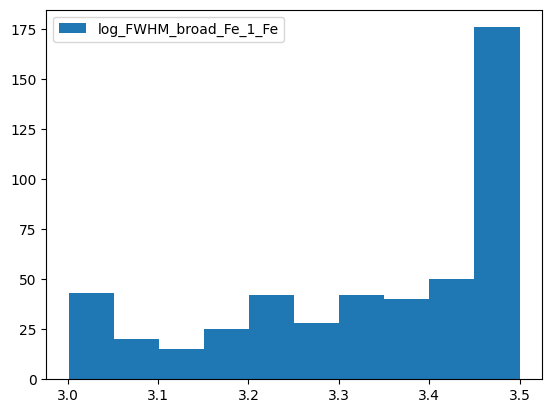

In [47]:
n_param = 27
plt.hist(Hbeta_class.params[:,n_param],label = list(Hbeta_class.params_dict.keys())[n_param] )
plt.legend()

In [158]:
jnp.log10(1100)

Array(3.04139269, dtype=float64)

In [48]:
Hbeta_class.params[:,n_param][27]

Array(3.42582197, dtype=float64)

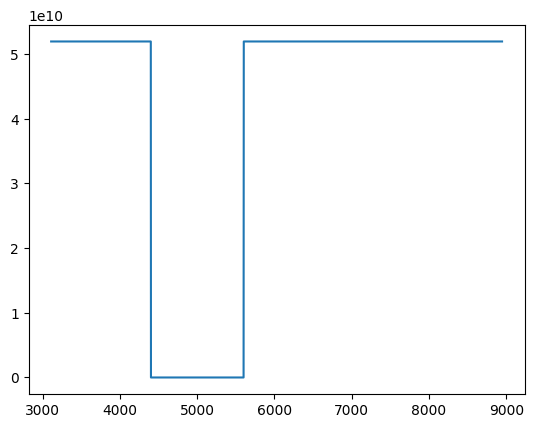

In [94]:
plt.plot(Hbeta_class.region_to_fit[12][0],Hbeta_class.region_to_fit[12][2])

In [51]:
#Hbeta_class.panda_params

In [40]:
ii = pd.DataFrame(Hbeta_class.initial_params)

In [55]:
region_panda[region_panda["kind"]=="Fe"]

,center,line_name,kind,component,profile,amplitude
17,4418.957000,FeIIa,Fe,20,guassian,0.1
18,4449.616000,FeIIb,Fe,20,guassian,0.1
19,4471.273000,FeIIc,Fe,20,guassian,0.1
20,4493.529000,FeIId,Fe,20,guassian,0.1
21,4614.551000,FeIIe,Fe,20,guassian,0.1
...,...,...,...,...,...,...
159,5477.237988,FeII34Fa,Fe,20,guassian,0.1
160,5527.610000,FeII34Fb,Fe,20,guassian,0.1
161,5746.970000,FeII34Fc,Fe,20,guassian,0.1
162,7155.160000,FeII14Fa,Fe,20,guassian,0.1


In [39]:
cc = pd.DataFrame(Hbeta_class.params,columns= list(Hbeta_class.params_dict.keys()))
cc[[c for c in cc.columns.values if "center" in c]]

,center_OIIc_1_narrow,center_TiII93a_1_narrow,center_TiII19b_1_narrow,center_TiII19c_1_narrow,center_NIII1a_1_narrow,center_CrII44a_1_narrow,center_NIIIc_1_narrow,center_NII5a_1_narrow,center_CIIIa_1_narrow,center_CIIIb_1_narrow,...,center_FeII34Fb_20_Fe,center_FeII34Fc_20_Fe,center_FeII14Fa_20_Fe,center_FeII14Fb_20_Fe,center_HeIId_1_narrow,center_HeIId_1_broad,center_HeId_1_narrow,center_HeId_1_broad,center_Hbeta_1_narrow,center_Hbeta_1_broad
0,4416.255437,4423.747323,4443.828023,4452.198068,4519.209187,4616.101017,4641.727860,4644.571008,4647.437653,4649.904057,...,5524.050241,5745.318821,7153.508821,7170.348821,4685.639263,4682.401732,4473.265183,4468.311859,4861.893581,4857.243341
1,4415.763560,4422.980564,4444.971848,4453.039675,4535.745405,4611.902568,4642.400868,4646.081068,4647.902573,4651.288510,...,5523.675608,5745.366817,7153.556817,7170.396817,4687.095683,4688.503226,4474.502487,4476.851081,4860.300102,4864.051728
2,4415.204909,4423.582208,4443.645443,4451.953889,4518.586098,4616.666251,4640.604232,4644.524831,4647.448976,4650.182177,...,5524.062096,5745.373261,7153.563261,7170.403261,4685.743523,4684.022567,4472.736994,4469.990665,4862.448609,4858.535825
3,4416.660995,4424.231037,4444.332535,4452.710226,4512.775036,4617.831829,4639.549520,4644.374489,4647.396753,4650.762564,...,5523.689182,5744.992528,7153.182528,7170.022528,4687.097689,4679.004858,4473.788785,4463.682377,4861.833854,4852.676166
4,4416.518806,4424.688641,4444.887503,4452.642557,4514.364211,4618.053912,4643.089831,4646.071760,4648.117354,4650.984314,...,5523.821962,5745.271505,7153.461505,7170.301505,4687.328283,4686.341929,4477.180212,4471.771644,4863.217137,4861.397527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,4418.449838,4424.412639,4441.456931,4450.511102,4513.366493,4618.255858,4641.516609,4644.094292,4648.361489,4651.084401,...,5523.568407,5745.181478,7153.371478,7170.211478,4686.271899,4679.794569,4473.837071,4465.989802,4857.630353,4852.824859
496,4417.055913,4425.185189,4445.283598,4453.749140,4517.136343,4620.294374,4641.308026,4644.590377,4649.033852,4651.847966,...,5525.853433,5747.018910,7155.208910,7172.048910,4687.041159,4676.635601,4474.778938,4461.545918,4863.708279,4850.675389
497,4416.980297,4425.217061,4442.281713,4453.191928,4516.160605,4615.880225,4644.023688,4646.865070,4649.817570,4653.103123,...,5526.727678,5747.481966,7155.671966,7172.511966,4688.392325,4680.368445,4474.942814,4452.849173,4864.135396,4845.242597
498,4417.082517,4424.112408,4444.191805,4450.292626,4511.665895,4617.062662,4641.845942,4644.572536,4648.024229,4650.821114,...,5524.314730,5745.322962,7153.512962,7170.352962,4686.640472,4687.624419,4474.752327,4473.403013,4862.472965,4861.628739


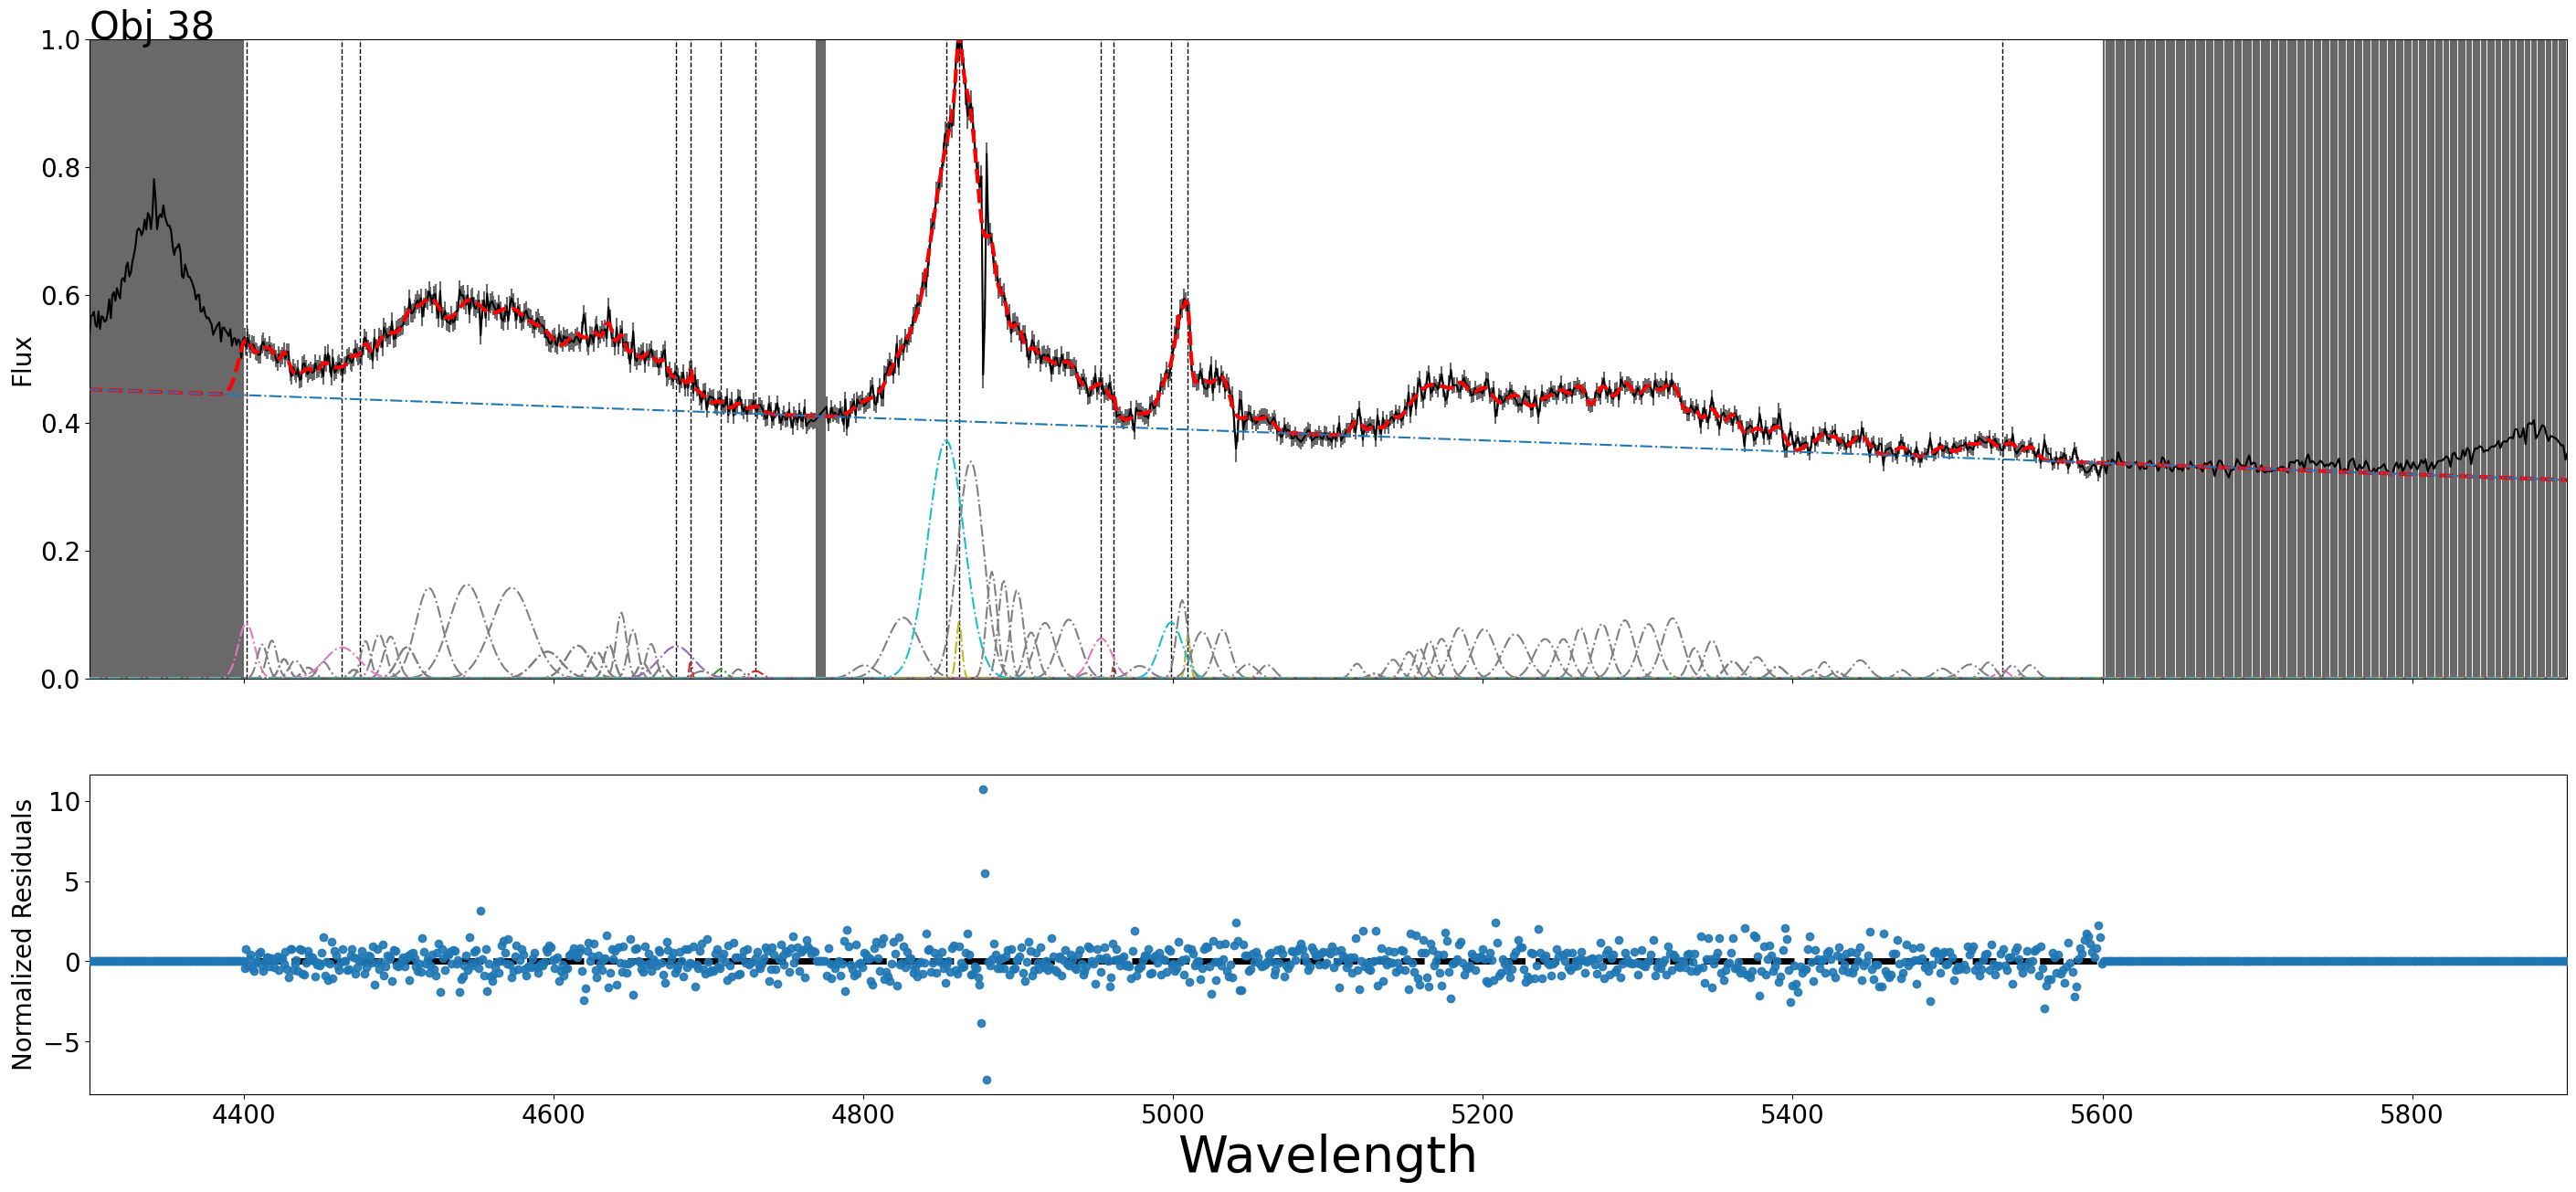

In [93]:
n = 38
region_plot = SheapRegionplot(Hbeta_class)
region_plot.plot(n,xlim=[4300, 5900],ylim=[0,1])#207
#objs_panda_sort.iloc[n]

In [50]:
from astropy.io import fits

In [51]:
file_ = fits.open(objs_panda.iloc[n].fit_path)

(2500.0, 4000.0)

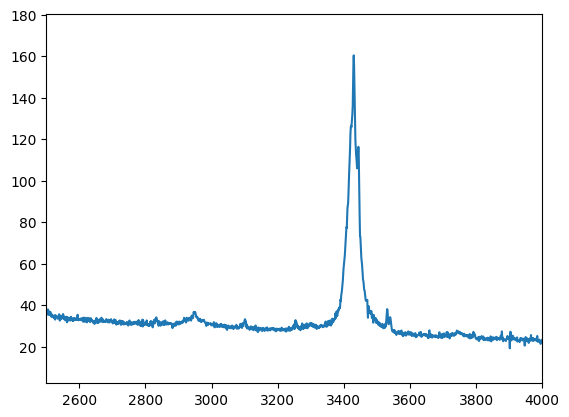

In [65]:
plt.plot(file_[1].data['flux'])
plt.xlim(2500,4000)

In [33]:
objs_panda[objs_panda["SDSS_NAME"]== "132059.42+295728.1"]

,SDSS_NAME,Z_DR16Q,FHOST_5100,Z_FIT,PLATE,MJD,FIBERID,RA,DEC,EBV,IF_BOSS_SDSS,SN_MEDIAN_ALL,LOGL5100,dr_name,fit_path
400,132059.42+295728.1,0.206057,0.0,0.206057,11401,58491,331,200.247599,29.957813,0.011451,BOSS,37.6791,44.424525,11401-58491-0331,/home/favila/smbh_mass/dr16/new_sub_sample_sds...
